In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from smt.surrogate_models import KRG
from juliacall import Main as jl
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go

In [133]:
### CREATE DATA ARRAY ###

# Load the Julia file
jl.include("c:/Users/wongj_rl8z6/FlowLab/XFoil/write_xfoil.jl")

# Potential families of files to choose from
one_file = ["naca0012.dat"]
camber_files = ["naca0012.dat", "naca2412.dat", "naca4412.dat"]
thickness_files = ["naca0009.dat", "naca0012.dat", "naca0015.dat", "naca0018.dat"]

# Select which files to use
list_of_files =  camber_files

# Set parameters
alpha = list(range(-10, 16, 2))  # range of angle of attacks, in degrees
re = 1e5

# Convert Python list to Julia array
julia_list_of_files = jl.convert(jl.Array, list_of_files)
julia_alpha = jl.convert(jl.Array, [float(a) for a in alpha])

# Get data from julia
julia_data = jl.process_files(julia_list_of_files, julia_alpha, re)

# Create numpy array from julia data, make sure type is float
data_array = np.array(julia_data, dtype=float)

columns = {
    "alpha": 0,
    "c_l": 1,
    "c_d": 2,
    "c_dp": 3,
    "c_m": 4,
    "converged": 5,
    "camber": 6,
    "thickness": 7
}

# Access data using column names
alpha_values = data_array[:, columns["alpha"]]
c_l_values = data_array[:, columns["c_l"]]
c_d_values = data_array[:, columns["c_d"]]
c_dp_values = data_array[:, columns["c_dp"]]
c_m_values = data_array[:, columns["c_m"]]
converged_values = data_array[:, columns["converged"]]
camber_values = data_array[:, columns["camber"]]
thickness_values = data_array[:, columns["thickness"]]

    

In [134]:
### CHOOSE LIFT, DRAG, OR MOMENT COEFFICIENT ###

# Choose which coefficient to plot
focus = "lift"  # "lift", "drag", or "moment"

# Create inputs (xt) for alpha and camber plot
xt = np.column_stack((alpha_values, camber_values))

if focus == "lift":
    yt = c_l_values
    zlabel = "Lift Coefficient"
elif focus == "drag":
    yt = c_d_values
    zlabel = "Drag Coefficient"
elif focus == "moment":
    yt = c_m_values
    zlabel = "Moment Coefficient"


alpha_min = min(alpha_values)
alpha_max = max(alpha_values)
camber_min = min(camber_values)
camber_max = max(camber_values)
thickness_min = min(thickness_values)
thickness_max = max(thickness_values)

In [140]:
### CREATE MODEL ###

# Create the surrogate model
model = KRG()
model.set_training_values(xt, yt)
model.train()

# Create grid for prediction
alpha = np.linspace(alpha_min, alpha_max, 50)
camber = np.linspace(camber_min, camber_max, 50)
alpha_grid, camber_grid = np.meshgrid(alpha, camber)
xt_grid = np.c_[alpha_grid.ravel(), camber_grid.ravel()]
yt_grid = model.predict_values(xt_grid).reshape(alpha_grid.shape)

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 39
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  2.0237226
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 2500
   
   Predicting ...
   Predicting - done. Time (sec):  0.0114310
   
   Prediction time/pt. (sec) :  0.0000046
   


In [ ]:
### CHOOSE LIFT, DRAG, OR MOMENT COEFFICIENT ### TRY WITH OTHER DIM

# Choose which coefficient to plot
focus = "lift"  # "lift", "drag", or "moment"

if focus == "lift":
    yt = c_l_values
    zlabel = "Lift Coefficient"
elif focus == "drag":
    yt = c_d_values
    zlabel = "Drag Coefficient"
elif focus == "moment":
    yt = c_m_values
    zlabel = "Moment Coefficient"


# Create inputs (xt) for alpha and camber plot
other_dim = "camber" # "camber" or "thickness"

if other_dim == "camber":
    xt = np.column_stack((alpha_values, camber_values))
    second_dim = camber_values
elif other_dim == "thickness":
    xt = np.column_stack((alpha_values, thickness_values))
    second_dim = thickness_values

In [138]:
### CREATE MODEL ###  TRY SECOND DIM

# Create the surrogate model
model = KRG()
model.set_training_values(xt, yt)
model.train()

# Create grid for prediction
alpha = np.linspace(min(alpha_values), min(alpha_values), 50)
second_dim = np.linspace(min(second_dim), max(second_dim), 50)
alpha_grid, second_dim_grid = np.meshgrid(alpha, second_dim)
xt_grid = np.c_[alpha_grid.ravel(), second_dim_grid.ravel()]
yt_grid = model.predict_values(xt_grid).reshape(alpha_grid.shape)

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 39
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  2.1654410
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 2500
   
   Predicting ...
   Predicting - done. Time (sec):  0.0093133
   
   Prediction time/pt. (sec) :  0.0000037
   


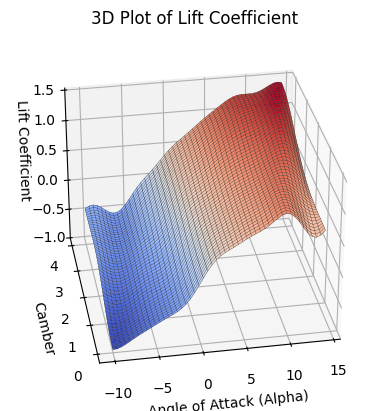

In [142]:
### PLOT MODEL W/O INTERACTIVE ###

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

if focus == "moment":
    ax.set_zlim(-0.25, 0.25)

# Plot the surface
ax.plot_surface(alpha_grid, camber_grid, yt_grid, cmap='coolwarm')

# Plot the wireframe
ax.plot_wireframe(alpha_grid, camber_grid, yt_grid, color='black', linewidth=0.2)

ax.set_xlabel('Angle of Attack (Alpha)')
ax.set_ylabel('Camber')
ax.set_zlabel(zlabel)
ax.set_title(f'3D Plot of {zlabel}')



# Change the camera angle
ax.view_init(elev=30, azim=260)

# Save the figure
# plt.savefig('C:/Users/wongj_rl8z6/ME595R/NeuralFoilFigures/Moment_camber_3d.png', dpi=300)

plt.show()

In [54]:
### CREATE INTERACTIVE PLOTS ###

# Create the surface plot
surface = go.Surface(
    x=alpha_grid,
    y=camber_grid,
    z=yt_grid,
    colorscale='Viridis'
)

# Create the layout
layout = go.Layout(
    title='Interactive 3D Plot of Lift Coefficient',
    scene=dict(
        xaxis_title='Angle of Attack (Alpha)',
        yaxis_title='Camber',
        zaxis_title='Lift Coefficient'
    )
)

# Create the figure
fig = go.Figure(data=[surface], layout=layout)

# Show the plot
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
### PLOT MODEL W/O INTERACTIVE ### with second_dim_grid

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

if focus == "moment":
    ax.set_zlim(-0.25, 0.25)

# Plot the surface
ax.plot_surface(alpha_grid, second_dim_grid, yt_grid, cmap='coolwarm')

# Plot the wireframe
ax.plot_wireframe(alpha_grid, second_dim_grid, yt_grid, color='black', linewidth=0.2)

ax.set_xlabel('Angle of Attack (Alpha)')
ax.set_ylabel('Camber')
ax.set_zlabel(zlabel)
ax.set_title(f'3D Plot of {zlabel}')



# Change the camera angle
ax.view_init(elev=30, azim=260)

# Save the figure
# plt.savefig('C:/Users/wongj_rl8z6/ME595R/NeuralFoilFigures/Moment_camber_3d.png', dpi=300)

plt.show()